In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [3]:
df_train = pd.read_parquet('../data/df_train.parquet')
df_val = pd.read_parquet('../data/df_val.parquet')
df_test = pd.read_parquet('../data/df_test.parquet')
df_full_train = pd.read_parquet('../data/df_full_train.parquet')
y_train = np.loadtxt('../data/y_train')
y_val = np.loadtxt('../data/y_val')
y_test = np.loadtxt('../data/y_test')


# Example of a decision tree

In [4]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [5]:
xi = df_train.iloc[0].to_dict()

In [6]:
assess_risk(xi)

'ok'

# Continue with decision trees for binary classification

In [7]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [8]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [9]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [12]:
roc_auc_score(y_val, y_pred)

np.float64(0.6562537841176043)

In [13]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

#### Este es un caso de overfitting, con los datos de entrenamiento las predicciones son perfectas pero con los datos de validación las predicciones son muy regulares

# Reentrenamos el modelo controlando la profundidad "DEPTH"

In [14]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [15]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('Train AUC:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('Validation AUC:', auc)

Train AUC: 0.7761016984958594
Validation AUC: 0.7389079944782155


## Visualize the tree

In [16]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0.0
|   |   |--- income >  74.50
|   |   |   |--- class: 0.0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1.0
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0.0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0.0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1.0
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1.0
|   |   |--- income >  103.50
|   |   |   |--- class: 0.0



# Decision trees parameter tuning

* Selecting max_depth
* Selecting min_samples_leaf

In [17]:
# max_depth

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s --> %.3f' % (d, auc))

   1 --> 0.606
   2 --> 0.669
   3 --> 0.739
   4 --> 0.761
   5 --> 0.766
   6 --> 0.753
  10 --> 0.686
  15 --> 0.666
  20 --> 0.648
None --> 0.667


In [18]:
# min_samples_leaf
scores = []

for d in [4, 5, 6, 7, 10, 15, 20]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [19]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10,15,0.790442
58,20,15,0.788277
49,15,15,0.787956
22,6,15,0.784856
41,10,20,0.783987


In [20]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc')
df_scores_pivot.round(3)

max_depth,4,5,6,7,10,15,20
min_samples_leaf,,,,,,,
1,0.761,0.766,0.752,0.732,0.673,0.653,0.657
2,0.761,0.766,0.755,0.743,0.712,0.697,0.683
5,0.761,0.768,0.762,0.758,0.726,0.715,0.719
10,0.761,0.762,0.778,0.764,0.770,0.763,0.762
15,0.764,0.772,0.785,0.780,0.790,0.788,0.788
20,0.761,0.774,0.774,0.779,0.784,0.782,0.783
100,0.756,0.763,0.776,0.780,0.780,0.780,0.779
200,0.747,0.759,0.768,0.768,0.768,0.768,0.768
500,0.680,0.680,0.680,0.680,0.680,0.680,0.680


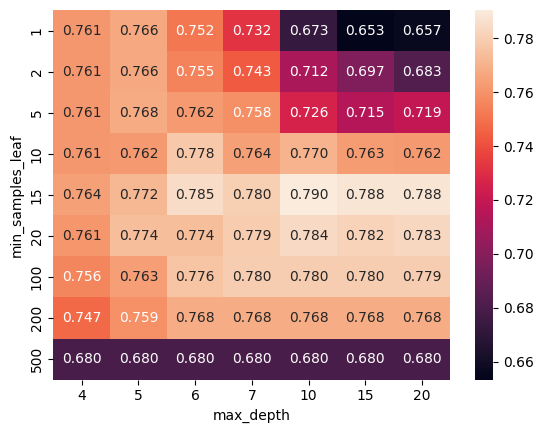

In [21]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')
plt.show()

In [22]:
# Final Decision Tree

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

# Ensamble and Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [25]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7744726453706618)

In [26]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))
        

In [27]:
columns = ['n_estimators', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.802239
2,30,0.811820
3,40,0.813912
4,50,0.815480
5,60,0.814872
6,70,0.816234
7,80,0.815081
8,90,0.815229
9,100,0.815665


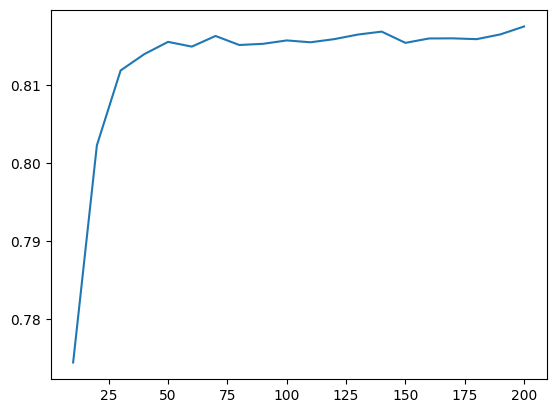

In [28]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

# Tuning more parameters for Random Forest


In [29]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 200, 10):
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            random_state=1
        )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [30]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


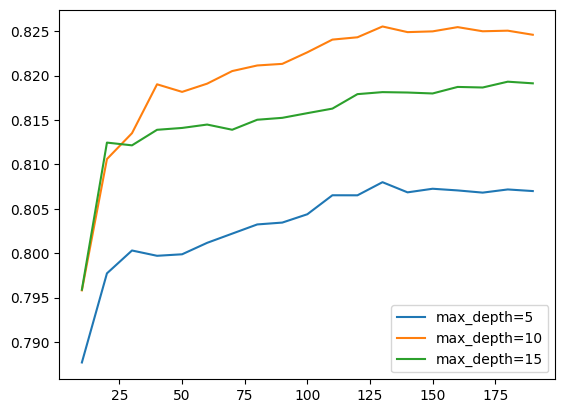

In [31]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()
plt.show()

In [32]:
max_depth = 10

In [33]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 200, 10):
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=max_depth,
            min_samples_leaf=s,
            random_state=1
        )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [34]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.795818
1,1,20,0.810597
2,1,30,0.813510
3,1,40,0.819013
4,1,50,0.818160
...,...,...,...
90,50,150,0.806050
91,50,160,0.806020
92,50,170,0.805191
93,50,180,0.805094


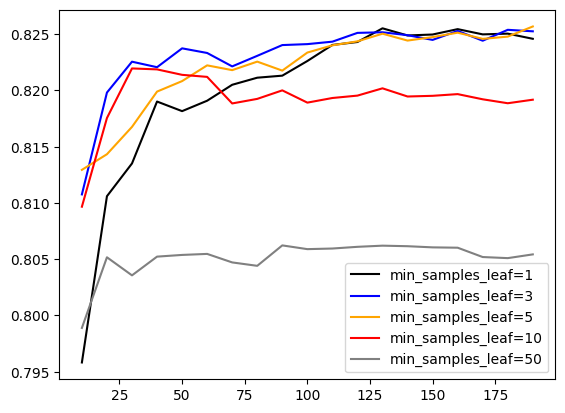

In [35]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()
plt.show()

In [36]:
min_samples_leaf = 3


min_samples_leaf = 3
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

# Gradient Boosting

In [37]:
import xgboost as xgb

In [39]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [44]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1
}


model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [45]:
y_pred = model.predict(dval)

In [46]:
roc_auc_score(y_val, y_pred)

np.float64(0.8152745150274878)

In [50]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5)

In [53]:
s = output.stdout
print(s)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

In [54]:

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [55]:
df_results = parse_xgb_output(output)
df_results.head()

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775


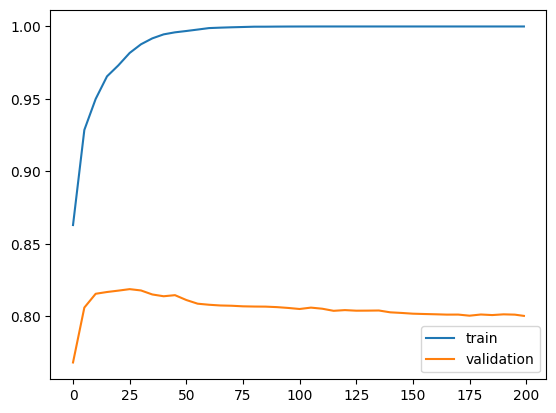

In [57]:
plt.plot(df_results.num_iter, df_results.train_auc, label='train')
plt.plot(df_results.num_iter, df_results.val_auc, label='validation')
plt.legend()
plt.show()



# XGBoost Parameter tunning

* eta
* max_depth
* min_child_weight

In [60]:
scores = {}

## eta or learning rate

In [73]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5)

In [74]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [76]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

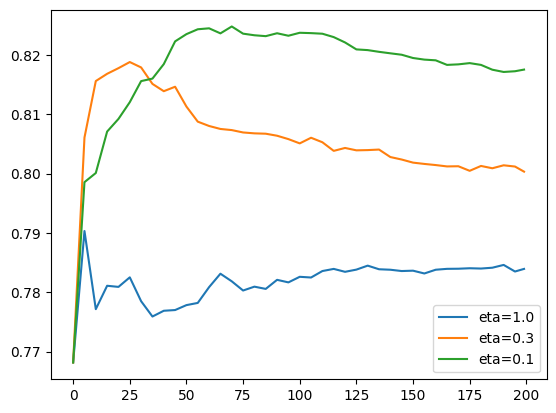

In [79]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=eta)
    
plt.legend()
plt.show()

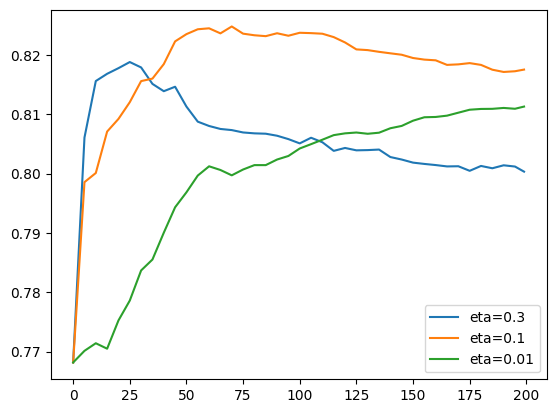

In [80]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=eta)
    
plt.legend()
plt.show()

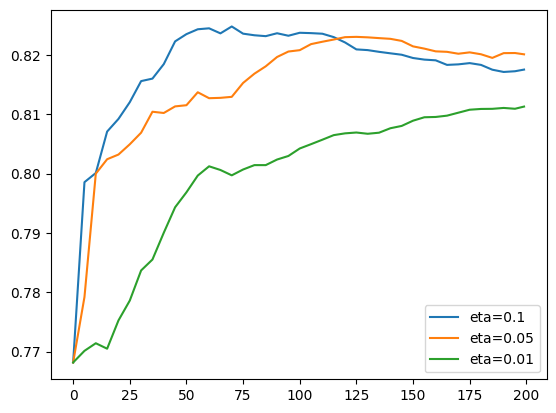

In [81]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=eta)
    
plt.legend()
plt.show()

Best eta=0.1

## Max Depth

In [82]:
scores = {}

In [91]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5)

In [92]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

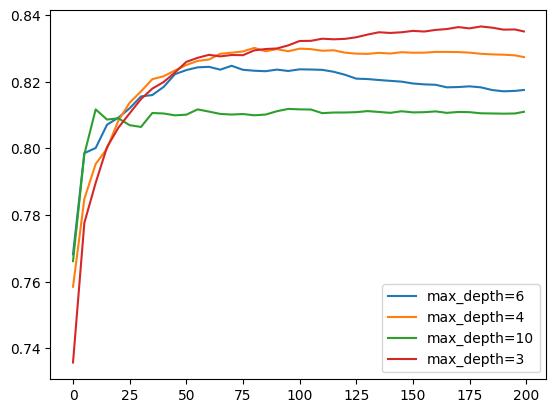

In [93]:
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_depth)

plt.legend()
plt.show()

In [94]:
del scores['max_depth=10']

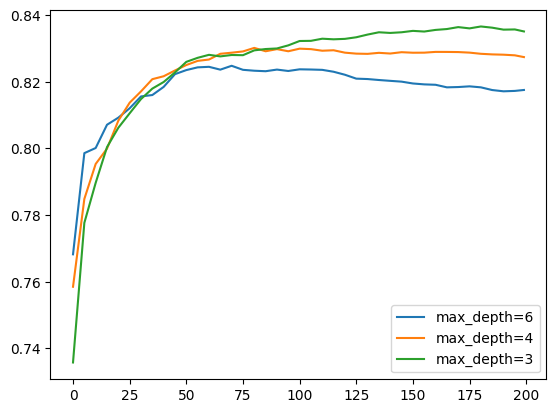

In [95]:
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_depth)

plt.legend()
plt.show()

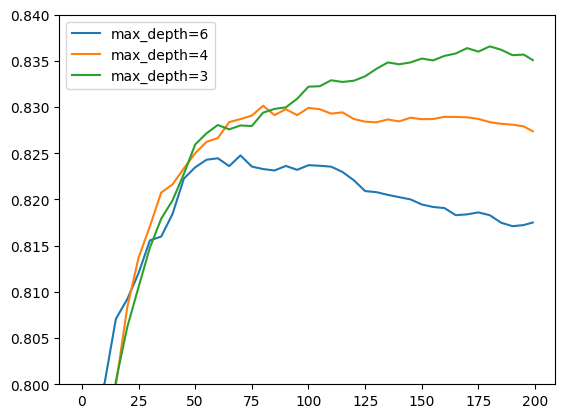

In [96]:
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()
plt.show()

best max_depth = 3

## Min Child Weight

In [100]:
scores = {}

In [105]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5)

In [106]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

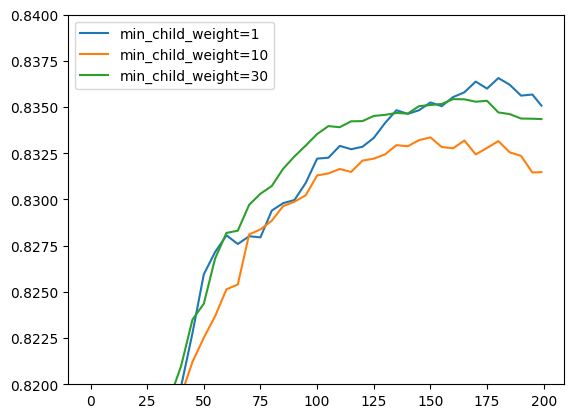

In [108]:
for min_child_weight, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()
plt.show()

best min_child_weight=1

# Final Model

In [110]:


xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=175)

# Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [111]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [113]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7854738320699426)

In [112]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=3,
    random_state=1
)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [114]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8249709379767989)

In [ ]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=175)

In [115]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8360387251459157)

XGBoost is the best model

lets train the model on the full training dataset

In [116]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype('int').values
del df_full_train['status']

In [117]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)


dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [124]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())


In [125]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed':1,
    'verbosity':1,
    'eval_metric': 'auc'
}


model = xgb.train(xgb_params, 
                  dfulltrain, 
                  num_boost_round=175)

In [126]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

np.float64(0.8322662626460096)